In [1]:
!nvidia-smi

Sun May 23 08:05:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

print('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')

CUDA GPU availalbe : True
1 GPU(s) is(are) allocated


In [3]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=0a4847b9765e73635a74ea9dde3ee8c0895c45a1cf753db3f6e98b534c0b7a23
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
import copy

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam, lr_scheduler, AdamW
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import KFold

train_dir = '/content/gdrive/MyDrive/Colab/dev-matching/train/'
test_dir = '/content/gdrive/MyDrive/Colab/dev-matching/test/0/'
csv_file = '/content/gdrive/MyDrive/Colab/dev-matching/test_answer_sample_.csv'

In [6]:
class_dic = {'dog' : 0,'elephant' : 1,'giraffe' : 2,'guitar' : 3,'horse' : 4,'house' : 5,'person' : 6}

In [7]:
class_folders = os.listdir(train_dir)

for cf in class_folders:
    print(cf, '(', class_dic[cf], '):', len(os.listdir(os.path.join(train_dir + cf))))

person ( 6 ): 399
dog ( 0 ): 329
horse ( 4 ): 151
guitar ( 3 ): 134
house ( 5 ): 245
giraffe ( 2 ): 235
elephant ( 1 ): 205


In [8]:
random.seed(40)

# # train val split
# indice = [i for i in range(1698)]
# validation_mask = random.sample(indice, int(len(indice) * 0.2))

In [9]:
# selected = []
# for i in range(len(train_data)):
#     if i in validation_mask:
#         selected.append(train_data[i])

# count = [0,0,0,0,0,0,0]
# for line in selected:
#     count[int(line.split('#')[0])] += 1
# count

In [10]:
train_data = []
for cf in class_folders:
    for jpg in os.listdir(os.path.join(train_dir + cf)):
        train_data.append(str(class_dic[cf]) + '#' + train_dir + cf + '/' + jpg)

In [11]:
class MyDataset(Dataset):
    def __init__(self, is_Train=True, transform=None):
        super().__init__()
        self.transform = transform

        train_data = []
        for cf in class_folders:
            for jpg in os.listdir(os.path.join(train_dir + cf)):
                train_data.append(str(class_dic[cf]) + '#' + train_dir + cf + '/' + jpg)

        # selected = []
        # if is_Train == True:
        #     for i in range(len(train_data)):
        #         if i not in validation_mask:
        #             selected.append(train_data[i])
        # else: # validation
        #     for i in range(len(train_data)):
        #         if i in validation_mask:
        #             selected.append(train_data[i])
        # self.train_data = selected

        self.train_data = train_data


    def __len__(self):
        return len(self.train_data)


    def __getitem__(self, idx):
        label, path = self.train_data[idx].split('#')
        img = Image.open(path)

        if self.transform:
            img = self.transform(img)

        return img, int(label)

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=7)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
net = Net()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [22]:
batch_size = 28
epochs = 30
lr = 5e-4

In [15]:
transform_train = transforms.Compose([
    transforms.RandomRotation(20),
    torchvision.transforms.RandomCrop((200, 200)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomChoice([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.01),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0))
]),
    #transforms.Resize((200,200), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])

transform_val = transforms.Compose([
    #transforms.Resize((200,200), Image.BILINEAR),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomChoice([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.01),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0))
]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = MyDataset(is_Train=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True,
                          num_workers=4, shuffle=True)

valid_dataset = MyDataset(is_Train=False, transform=transform_val)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, num_workers=4)

In [16]:
# -- Focal Loss
# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=1.2, reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

# -- Cross Entropy Loss
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

# -- Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=7, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [27]:
# criterion = nn.CrossEntropyLoss()
criterion1 = CrossEntropyLoss()
criterion2 = FocalLoss()
criterion3 = LabelSmoothingLoss()
optimizer = AdamW(net.parameters(), lr=lr, weight_decay=0.02)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2, eta_min=0.00001)

In [18]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
      self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [19]:
model_name = "eff_b5"

In [28]:
kfold = KFold(n_splits=5, shuffle=True)

In [29]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_data)):
    print('-'*40)
    print(f'FOLD {fold}')
    print('-'*40)

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True,
                          num_workers=4, sampler=train_subsampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, num_workers=4,
                              sampler=test_subsampler)

    net = Net()
    net.cuda()
    optimizer = AdamW(net.parameters(), lr=lr, weight_decay=0.02)
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('='*12)
        
        # Train
        for iter, (img, label) in enumerate(train_loader):
            optimizer.zero_grad()
            img, label = img.type(torch.FloatTensor).cuda(), label.cuda()
            pred_logit = net(img)
            loss1 = criterion1(pred_logit, label)
            loss2 = criterion2(pred_logit, label)
            loss3 = criterion3(pred_logit, label)
            loss = loss1 * 0.6 + loss2 * 0.3 + loss3 * 0.1
            loss.backward()
            optimizer.step()
            train_loss = loss.item()
    
            # Validation
            if (iter == len(train_loader)-1):
                valid_acc = AverageMeter()
                loss_total = 0

                for img, label in valid_loader:
                    img, label = img.type(torch.FloatTensor).cuda(), label.cuda()
                    with torch.no_grad():
                        pred_logit = net(img)
                    #loss = criterion(pred_logit, label)
                    loss1 = criterion1(pred_logit, label)
                    loss2 = criterion2(pred_logit, label)
                    loss3 = criterion3(pred_logit, label)
                    loss = loss1 * 0.6 + loss2 * 0.3 + loss3 * 0.1
                    loss_total += loss.item()

                    # Accuracy 계산
                    pred_label = torch.max(pred_logit, 1)[1]
                    acc = (pred_label == label).sum() / np.float(len(img))
    
                    valid_acc.update(acc, len(img))

                valid_loss = loss_total / len(img)
                valid_acc = valid_acc.avg
                current_lr = scheduler.get_last_lr()

                print("Iter [%3d/%3d] | Train Loss %.4f | Valid Loss %.4f | Valid Acc %.4f | lr %.5f" %
                    (iter, len(train_loader), train_loss, valid_loss, valid_acc, current_lr[0]))

                # writer.add_scalar('training loss', train_loss, epoch * len(train_loader) + iter)
                # writer.add_scalar('validation loss', valid_loss, epoch * len(train_loader) + iter)
                # writer.add_scalar('validation acc', valid_acc, epoch * len(train_loader) + iter)
                
                
                if valid_acc > best_acc or epoch % 20 == 0:
                    best_acc = valid_acc
                    best_model_weights = copy.deepcopy(net.state_dict())

                    torch.save(best_model_weights, f'/content/gdrive/MyDrive/Colab/dev-matching/model/fold{fold}_{model_name}_{epoch + 1}.pth')
                    print("Best model saved in epoch {} | Acc {:.4f}".format(epoch + 1, best_acc))
                
                best_model_weights = copy.deepcopy(net.state_dict())
                
        if epoch < epochs:
            scheduler.step()
        

        
        
print('Finished training')

----------------------------------------
FOLD 0
----------------------------------------
Loaded pretrained weights for efficientnet-b4
Epoch 1/30
Iter [ 48/ 49] | Train Loss 0.5762 | Valid Loss 1.6095 | Valid Acc 0.8353 | lr 0.00050
Best model saved in epoch 1 | Acc 0.8353
Epoch 2/30


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Iter [ 48/ 49] | Train Loss 0.3068 | Valid Loss 2.0280 | Valid Acc 0.8559 | lr 0.00026
Best model saved in epoch 2 | Acc 0.8559
Epoch 3/30
Iter [ 48/ 49] | Train Loss 0.0750 | Valid Loss 1.2257 | Valid Acc 0.8735 | lr 0.00001
Best model saved in epoch 3 | Acc 0.8735
Epoch 4/30
Iter [ 48/ 49] | Train Loss 0.2858 | Valid Loss 1.0548 | Valid Acc 0.8853 | lr 0.00025
Best model saved in epoch 4 | Acc 0.8853
Epoch 5/30
Iter [ 48/ 49] | Train Loss 0.3223 | Valid Loss 1.2457 | Valid Acc 0.8735 | lr 0.00050
Epoch 6/30
Iter [ 48/ 49] | Train Loss 0.1874 | Valid Loss 1.0682 | Valid Acc 0.8853 | lr 0.00026
Epoch 7/30
Iter [ 48/ 49] | Train Loss 0.0568 | Valid Loss 1.1273 | Valid Acc 0.8853 | lr 0.00001
Epoch 8/30
Iter [ 48/ 49] | Train Loss 0.1008 | Valid Loss 1.0514 | Valid Acc 0.9059 | lr 0.00025
Best model saved in epoch 8 | Acc 0.9059
Epoch 9/30
Iter [ 48/ 49] | Train Loss 0.1722 | Valid Loss 2.0011 | Valid Acc 0.8735 | lr 0.00050
Epoch 10/30
Iter [ 48/ 49] | Train Loss 0.0109 | Valid Loss 1.2

KeyboardInterrupt: ignored

# Inference

In [31]:
class TestDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        test_list = os.listdir(os.path.join(test_dir))
        test_list.sort()
        test_data = []
        for jpg in test_list:
            test_data.append(test_dir + '/' + jpg)

        self.test_data = test_data

    def __getitem__(self, idx):
        img = Image.open(self.test_data[idx])

        if self.transform:
            img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.test_data)

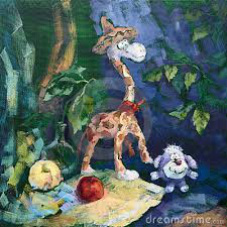

In [32]:
td = TestDataset()
td[0]

In [ ]:
submission = pd.read_csv(csv_file)
dataset = TestDataset(transform_val)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
model = Net()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab/dev-matching/model/fold1_eff_b5_22.pth'))
model.eval()
model.cuda()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for img in loader:
    img = img.type(torch.FloatTensor).cuda()
    with torch.no_grad():
        pred_logit = model(img)
        pred = pred_logit.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['answer value'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join('/content/gdrive/MyDrive/Colab/dev-matching/', 'submission.csv'), index=False)
print('test inference is done!')

In [ ]:
# Ensemble inference

submission5 = pd.read_csv(csv_file)
dataset = TestDataset(transform_val)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

model = Net()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab/dev-matching/model/fold4_eff_b5_15.pth'))
model.eval()
model.cuda()

all_predictions = []
for img in loader:
    img = img.type(torch.FloatTensor).cuda()
    with torch.no_grad():
        pred_logit = model(img)
        #pred = pred_logit.argmax(dim=-1)
        #all_predictions.extend(pred.cpu().numpy())
        all_predictions.extend(pred_logit.cpu().numpy())
submission5['answer value'] = all_predictions

In [ ]:
submission = submission1 + submission2 + submission3 + submission4 + submission5

final = pd.read_csv(csv_file)

for i, pred in enumerate(submission['answer value']):
    final['answer value'][i] = np.argmax(pred)

final.to_csv(os.path.join('/content/gdrive/MyDrive/Colab/dev-matching/', 'submission.csv'), index=False)
print('test inference is done!')